In [1]:
##### from pygradu import gridify
from pygradu import shortest_path
from pygradu import gridify
from pygradu import portcalls

import shapely.geometry
import pandas as pd
import numpy as np
import importlib

RESULTS_DIR = 'data/results/'
DATASET_DIR = 'data/datasets/'
SHAPES_DIR = 'data/shapes/'

importlib.reload(gridify)

grid_2500m = gridify.area_to_grid(side_length=2500)
grid_5km = gridify.area_to_grid(side_length=5000)

validation_voyages_summer = pd.read_csv(DATASET_DIR + 'validation_set_summer.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])
validation_voyages_winter = pd.read_csv(DATASET_DIR + 'validation_set_winter.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])

validation_voyages_summer_simulated = pd.read_csv(RESULTS_DIR + 'summer_simulated_actual_voyages.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])
validation_voyages_winter_simulated = pd.read_csv(RESULTS_DIR + 'winter_simulated_actual_voyages.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])

Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 573
row_count 552
grid_size 316296
Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 286
row_count 276
grid_size 78936


In [2]:
# Load stuff
summer_results_5km_adj = pd.read_csv(RESULTS_DIR + 'summer_results_5km_adj_to_end.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
summer_results_5km_ship = pd.read_csv(RESULTS_DIR + 'summer_results_5km_ship_to_end.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
summer_results_2500m_adj = pd.read_csv(RESULTS_DIR + 'summer_results_2500m_adj_to_end.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])

winter_results_5km_adj_no_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_to_end_5km_adj_no_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
winter_results_5km_adj_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_to_end_5km_adj_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
winter_results_5km_ship_no_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_5km_ship_to_end_no_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
winter_results_5km_ship_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_5km_ship_to_end_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
winter_results_2500m_adj_no_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_2500m_ship_to_end_no_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
winter_results_2500m_adj_dirway = pd.read_csv(RESULTS_DIR + 'winter_results_2500m_ship_to_end_dirways.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])


winter_simulated_results_ship_5km_no_dirway = pd.read_csv(RESULTS_DIR + 'winter_simulated_results_ship_5km_no_dirway.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
winter_simulated_results_ship_5km_dirway = pd.read_csv(RESULTS_DIR + 'winter_simulated_results_ship_5km_dirway.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])

summer_simulated_results_ship_5km = pd.read_csv(RESULTS_DIR + 'summer_simulated_results_ship_5km.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])
summer_simulated_results_adj_5km = pd.read_csv(RESULTS_DIR + 'summer_simulated_results_adj_5km.csv', index_col=0, parse_dates = ['start_time', 'pred_time'])

In [3]:
summer_unique_end_ports = len(summer_results_5km_adj.end_port.drop_duplicates())
print('In the summer validation set there are voyages to %2d different ports' % summer_unique_end_ports)

In the summer validation set there are voyages to 72 different ports


In [4]:
winter_unique_end_ports = len(winter_results_5km_adj_dirway.end_port.drop_duplicates())
print('In the winter validation set there are voyages to %2d different ports' % winter_unique_end_ports)

In the winter validation set there are voyages to 25 different ports


In [5]:
#### Helper columns and variables for result examination

In [6]:
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open(SHAPES_DIR + 'sea_areas.geojson') as f:
    sea_areas = json.load(f)

def get_sea_area_from_latlon(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['id']
    return -1

def get_sea_area_name_from_latlon(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'South'

def get_sea_area_name(sea_areas, _id):
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if int(feature['properties']['id']) == int(_id):
            return feature['properties']['name']
    return 'South'

In [7]:
def get_eta_results(results, validation_set, voyages, voyage_lengths):
    eta_results = []
    for voyage, voyage_results in results.groupby('voyage'):
        start = voyage_results.head(1).iloc[0]
        end = voyage_results.tail(1).iloc[0]

        pred_end_time = end.pred_time
        actual_end_time = validation_set[validation_set.voyage == voyage].timestamp.max()

        actual_start_time = validation_set[validation_set.voyage == voyage].timestamp.min()
        
        voyage_length_km = voyage_lengths[voyage_lengths.voyage == voyage].iloc[0].voyage_length

        diff_mins = (actual_end_time - pred_end_time).total_seconds() / 60
        voyage_length_mins = voyage_lengths[voyage_lengths.voyage == voyage].iloc[0].travel_time

        over_predicted = 1
        if diff_mins < 0:
            over_predicted = 0

        start_port = voyages[voyages.voyage == voyage].iloc[0].start_port

        eta_results.append([voyage, actual_end_time, pred_end_time, abs(diff_mins), over_predicted, voyage_length_mins, voyage_length_km, start.vessel_type, start.start_port_sea_area, start.end_port_sea_area, start_port, start.end_port])

    return pd.DataFrame(data=eta_results, columns=['voyage', 'actual_end_time', 'pred_end_time', 'diff_mins', 'over_predicted', 'voyage_length_mins', 'voyage_length_km', 'vessel_type', 'start_port_sea_area', 'end_port_sea_area', 'start_port', 'start.end_port'])


In [8]:
ports = pd.read_csv(DATASET_DIR + 'ports.csv')
ports = ports[['port_id', 'lat', 'lon']]
print(len(ports))

ais_ports = pd.read_csv(DATASET_DIR + 'ports_calculated_from_ais.csv')
ais_ports = ais_ports[['id', 'lat', 'lon']]
ais_ports.columns=['port_id', 'lat', 'lon']

ports = ports.append(ais_ports)

157


In [9]:
importlib.reload(portcalls)

%time voyages_summer_lengths = portcalls.get_voyage_lengths(validation_voyages_summer)
%time voyages_winter_lengths = portcalls.get_voyage_lengths(validation_voyages_winter)
voyages_summer_lengths.head()

CPU times: user 23.5 s, sys: 248 ms, total: 23.8 s
Wall time: 23.8 s
CPU times: user 11.8 s, sys: 122 ms, total: 11.9 s
Wall time: 12 s


,voyage,voyage_length,start_end_length,difference,travel_time,avg_speed
0,14,393.001082,331.910305,18.405809,1366.066667,4.801574
1,67,509.627510,457.719607,11.340546,1442.483333,5.888805
2,88,612.745803,438.626106,39.696611,1723.316667,5.917536
3,93,1330.034728,1137.075860,16.969745,3856.666667,5.751125
4,94,842.476910,616.033928,36.758200,2349.216667,5.984929


In [10]:
importlib.reload(portcalls)

%time voyages_simulated_summer_lengths = portcalls.get_voyage_lengths(validation_voyages_summer_simulated)
%time voyages_simulated_winter_lengths = portcalls.get_voyage_lengths(validation_voyages_winter_simulated)
voyages_simulated_summer_lengths.head()

CPU times: user 2min 16s, sys: 1.55 s, total: 2min 18s
Wall time: 2min 20s
CPU times: user 2min 18s, sys: 1.63 s, total: 2min 19s
Wall time: 2min 21s


,voyage,voyage_length,start_end_length,difference,travel_time,avg_speed
0,1616_0,885.410210,705.626569,25.478582,3169.516667,4.666260
1,1616_1020,587.244467,540.865852,8.574883,2149.116667,4.552150
2,1616_1080,571.476044,526.222869,8.599622,2088.016667,4.559950
3,1616_1140,555.731060,511.613721,8.623173,2026.783333,4.567846
4,1616_120,852.591801,685.175651,24.434048,3045.116667,4.676575


In [11]:
importlib.reload(portcalls)

voyages_summer = summer_results_5km_adj[['voyage', 'vessel_type', 'end_port', 'end_port_sea_area', 'start_time']].drop_duplicates()
voyages_summer['start_lat'] = voyages_summer.apply(lambda row: summer_results_5km_adj[summer_results_5km_adj.voyage == row.voyage].head(1).iloc[0].actual_lat, axis=1)
voyages_summer['start_lon'] = voyages_summer.apply(lambda row: summer_results_5km_adj[summer_results_5km_adj.voyage == row.voyage].head(1).iloc[0].actual_lon, axis=1)
voyages_summer['start_sea_area'] = voyages_summer.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.start_lat, row.start_lon), axis=1)
voyages_summer['start_port'] = voyages_summer.apply(lambda row: portcalls.get_port_id(row, ports), axis=1)

In [12]:
importlib.reload(portcalls)

voyages_winter = winter_results_5km_adj_no_dirway[['voyage', 'vessel_type', 'end_port', 'end_port_sea_area', 'start_time']].drop_duplicates()
voyages_winter['start_lat'] = voyages_winter.apply(lambda row: winter_results_5km_adj_no_dirway[winter_results_5km_adj_no_dirway.voyage == row.voyage].head(1).iloc[0].actual_lat, axis=1)
voyages_winter['start_lon'] = voyages_winter.apply(lambda row: winter_results_5km_adj_no_dirway[winter_results_5km_adj_no_dirway.voyage == row.voyage].head(1).iloc[0].actual_lon, axis=1)
voyages_winter['start_sea_area'] = voyages_winter.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.start_lat, row.start_lon), axis=1)
voyages_winter['start_port'] = voyages_summer.apply(lambda row: portcalls.get_port_id(row, ports), axis=1)

In [13]:
importlib.reload(portcalls)

voyages_simulated_winter = winter_simulated_results_ship_5km_dirway[['voyage', 'vessel_type', 'end_port', 'end_port_sea_area', 'start_time']].drop_duplicates()
voyages_simulated_winter['start_lat'] = voyages_simulated_winter.apply(lambda row: winter_simulated_results_ship_5km_dirway[winter_simulated_results_ship_5km_dirway.voyage == row.voyage].head(1).iloc[0].actual_lat, axis=1)
voyages_simulated_winter['start_lon'] = voyages_simulated_winter.apply(lambda row: winter_simulated_results_ship_5km_dirway[winter_simulated_results_ship_5km_dirway.voyage == row.voyage].head(1).iloc[0].actual_lon, axis=1)
voyages_simulated_winter['start_sea_area'] = voyages_simulated_winter.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.start_lat, row.start_lon), axis=1)
voyages_simulated_winter['start_port'] = voyages_simulated_winter.apply(lambda row: portcalls.get_port_id(row, ports), axis=1)

In [14]:
importlib.reload(portcalls)

voyages_simulated_summer = summer_simulated_results_ship_5km[['voyage', 'vessel_type', 'end_port', 'end_port_sea_area', 'start_time']].drop_duplicates()
voyages_simulated_summer['start_lat'] = voyages_simulated_summer.apply(lambda row: summer_simulated_results_ship_5km[summer_simulated_results_ship_5km.voyage == row.voyage].head(1).iloc[0].actual_lat, axis=1)
voyages_simulated_summer['start_lon'] = voyages_simulated_summer.apply(lambda row: summer_simulated_results_ship_5km[summer_simulated_results_ship_5km.voyage == row.voyage].head(1).iloc[0].actual_lon, axis=1)
voyages_simulated_summer['start_sea_area'] = voyages_simulated_summer.apply(lambda row: get_sea_area_from_latlon(sea_areas, row.start_lat, row.start_lon), axis=1)
voyages_simulated_summer['start_port'] = voyages_simulated_summer.apply(lambda row: portcalls.get_port_id(row, ports), axis=1)

In [15]:
%time summer_results_5km_ship['start_port_sea_area'] = summer_results_5km_ship.apply(lambda row: voyages_summer[voyages_summer.voyage == row.voyage].iloc[0].start_sea_area, axis=1)

%time summer_simulated_results_ship_5km['start_port_sea_area'] = summer_simulated_results_ship_5km.apply(lambda row: voyages_simulated_summer[voyages_simulated_summer.voyage == row.voyage].iloc[0].start_sea_area, axis=1)
%time summer_simulated_results_adj_5km['start_port_sea_area'] = summer_simulated_results_adj_5km.apply(lambda row: voyages_simulated_summer[voyages_simulated_summer.voyage == row.voyage].iloc[0].start_sea_area, axis=1)

%time winter_simulated_results_ship_5km_dirway['start_port_sea_area'] = winter_simulated_results_ship_5km_dirway.apply(lambda row: voyages_simulated_winter[voyages_simulated_winter.voyage == row.voyage].iloc[0].start_sea_area, axis=1)
%time winter_simulated_results_ship_5km_no_dirway['start_port_sea_area'] = winter_simulated_results_ship_5km_no_dirway.apply(lambda row: voyages_simulated_winter[voyages_simulated_winter.voyage == row.voyage].iloc[0].start_sea_area, axis=1)


CPU times: user 44.7 s, sys: 261 ms, total: 45 s
Wall time: 44.9 s
CPU times: user 5min 9s, sys: 1.68 s, total: 5min 10s
Wall time: 5min 12s
CPU times: user 5min 7s, sys: 995 ms, total: 5min 8s
Wall time: 5min 8s
CPU times: user 5min 9s, sys: 953 ms, total: 5min 10s
Wall time: 5min 9s
CPU times: user 5min 5s, sys: 891 ms, total: 5min 6s
Wall time: 5min 6s


#### ETA result examination

In [16]:
%time winter_results_5km_ship_no_dirway['start_port_sea_area'] = winter_results_5km_ship_no_dirway.apply(lambda row: voyages_winter[voyages_winter.voyage == row.voyage].iloc[0].start_sea_area, axis=1)
%time winter_results_5km_ship_dirway['start_port_sea_area'] = winter_results_5km_ship_dirway.apply(lambda row: voyages_winter[voyages_winter.voyage == row.voyage].iloc[0].start_sea_area, axis=1)

summer_eta_results = get_eta_results(summer_results_5km_ship, validation_voyages_summer, voyages_summer, voyages_summer_lengths)
winter_eta_results_no_dirway = get_eta_results(winter_results_5km_ship_no_dirway, validation_voyages_winter, voyages_winter, voyages_winter_lengths)
winter_eta_results_dirway = get_eta_results(winter_results_5km_ship_dirway, validation_voyages_winter, voyages_winter, voyages_winter_lengths)

CPU times: user 23.6 s, sys: 145 ms, total: 23.8 s
Wall time: 23.3 s
CPU times: user 23.5 s, sys: 151 ms, total: 23.7 s
Wall time: 23.6 s


In [17]:
winter_eta_results_no_dirway.describe()

,voyage,diff_mins,over_predicted,voyage_length_mins,voyage_length_km,start_port_sea_area,end_port_sea_area,start_port,start.end_port
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0000,0.0,8.000000e+01
mean,306.775000,381.459578,0.762500,2936.846458,1105.643296,3.200000,1.5625,NaN,4.231688e+04
std,179.053275,334.216770,0.428236,1448.036643,593.580224,3.803396,2.6282,NaN,3.363234e+05
min,5.000000,0.000000,0.000000,275.166667,80.657340,-1.000000,-1.0000,NaN,9.310000e+02
25%,140.250000,147.083333,1.000000,1778.166667,533.323026,1.000000,-1.0000,NaN,9.990000e+02
50%,338.000000,276.258333,1.000000,3404.391667,1119.179805,1.000000,1.0000,NaN,1.073000e+03
75%,437.250000,573.275000,1.000000,3890.166667,1673.298225,3.500000,2.2500,NaN,6.652000e+03
max,627.000000,1834.500000,1.000000,6673.816667,1966.384680,11.000000,9.0000,NaN,3.012222e+06


In [18]:
winter_eta_results_dirway.describe()

,voyage,diff_mins,over_predicted,voyage_length_mins,voyage_length_km,start_port_sea_area,end_port_sea_area,start_port,start.end_port
count,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,80.0000,0.0,8.000000e+01
mean,306.775000,375.959446,0.66250,2936.846458,1105.643296,3.200000,1.5625,NaN,4.231688e+04
std,179.053275,325.127059,0.47584,1448.036643,593.580224,3.803396,2.6282,NaN,3.363234e+05
min,5.000000,0.000000,0.00000,275.166667,80.657340,-1.000000,-1.0000,NaN,9.310000e+02
25%,140.250000,129.612500,0.00000,1778.166667,533.323026,1.000000,-1.0000,NaN,9.990000e+02
50%,338.000000,256.526175,1.00000,3404.391667,1119.179805,1.000000,1.0000,NaN,1.073000e+03
75%,437.250000,537.004167,1.00000,3890.166667,1673.298225,3.500000,2.2500,NaN,6.652000e+03
max,627.000000,1651.300000,1.00000,6673.816667,1966.384680,11.000000,9.0000,NaN,3.012222e+06


In [19]:
summer_eta_results.describe()

,voyage,diff_mins,over_predicted,voyage_length_mins,voyage_length_km,start_port_sea_area,end_port_sea_area,start_port,start.end_port
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,2.800000e+02,3.300000e+02
mean,3299.927273,174.236254,0.739394,1422.086162,516.031082,13.333333,6.090909,8.433189e+05,1.045565e+06
std,1756.757853,226.148714,0.439632,1013.877433,343.622339,77.179366,4.083949,2.438744e+06,2.493300e+06
min,14.000000,0.683597,0.000000,67.950000,9.368543,-1.000000,-1.000000,9.150000e+02,9.230000e+02
25%,2254.250000,41.612500,0.000000,638.200000,284.000496,5.000000,3.000000,9.750000e+02,1.007000e+03
50%,2996.000000,101.858333,1.000000,1118.750000,404.163412,8.000000,6.000000,1.051000e+03,2.345000e+03
75%,4895.000000,205.291667,1.000000,1857.175000,635.502617,11.000000,10.000000,1.411950e+04,1.976225e+04
max,6576.000000,1562.133333,1.000000,5353.933333,2029.400648,999.000000,13.000000,1.583330e+07,8.616642e+06


#### Histogram of under predicted vs over predicted

In [20]:
import matplotlib.pyplot as plt

summer_eta_results[['over_predicted']].hist(figsize=(10,10), grid=False, xlabelsize=15, ylabelsize=15)
plt.title('')
plt.xlabel("ETA Prediction Error in Minutes", fontsize=23)
plt.ylabel("Frequency",fontsize=23)
plt.show()

<Figure size 1000x1000 with 1 Axes>

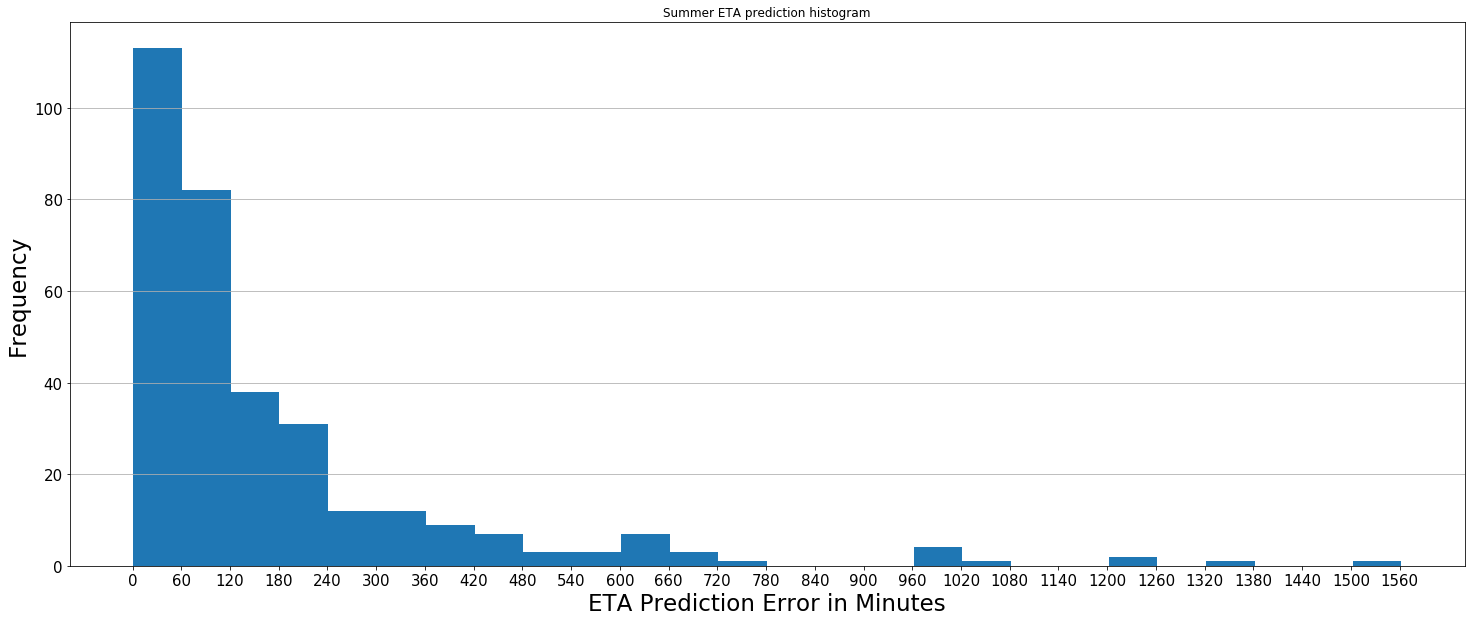

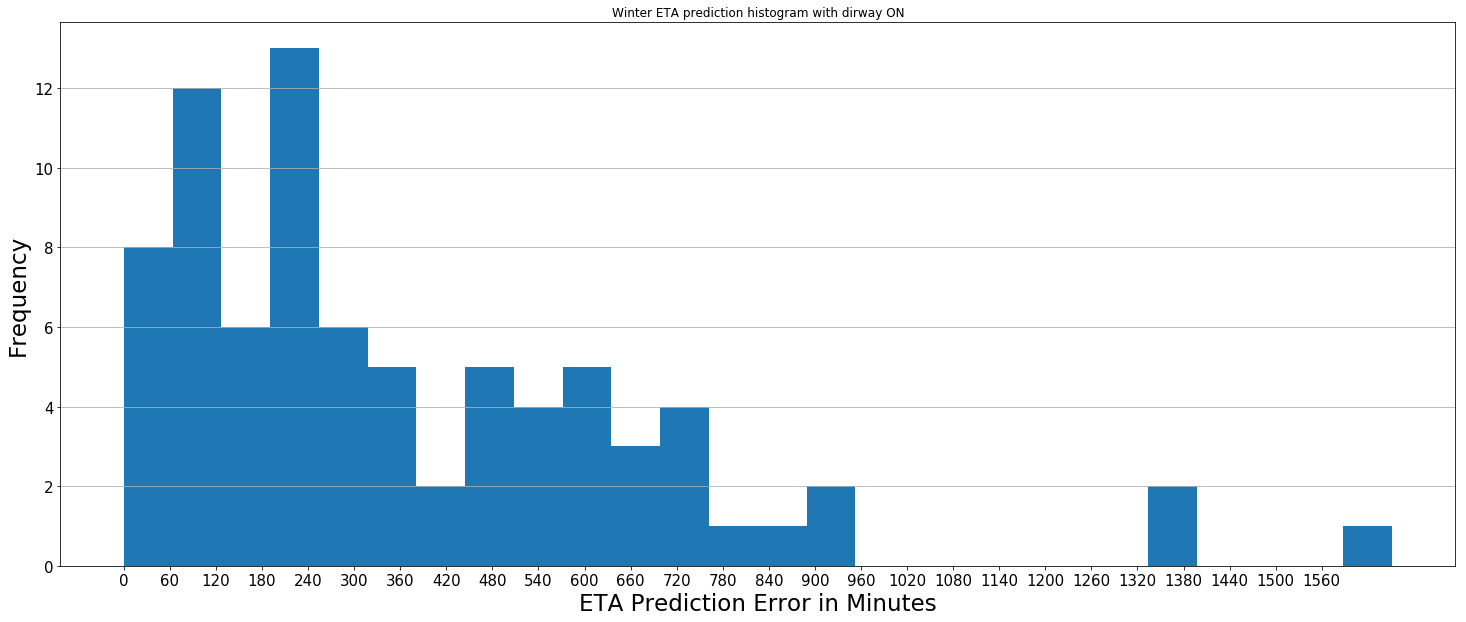

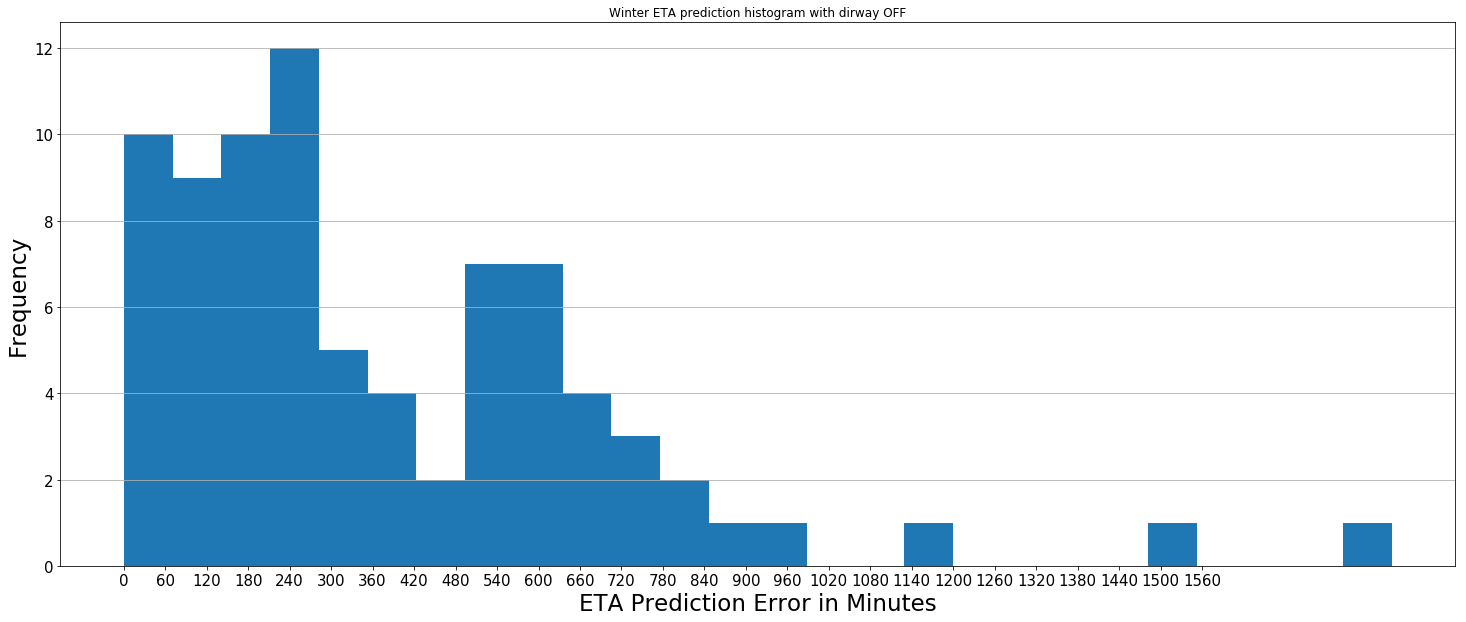

In [21]:
import matplotlib.pyplot as plt

summer_eta_results[['diff_mins']].hist(figsize=(25,10), bins=26, grid=False, xlabelsize=15, ylabelsize=15)
plt.xticks(np.arange(0, 1600, 60)) 
plt.xlabel("ETA Prediction Error in Minutes", fontsize=23)
plt.ylabel("Frequency",fontsize=23)
plt.title('Summer ETA prediction histogram')
plt.grid(axis='y', alpha=1)
plt.show()


winter_eta_results_dirway[['diff_mins']].hist(figsize=(25,10), bins=26, grid=False, xlabelsize=15, ylabelsize=15)
plt.xticks(np.arange(0, 1600, 60)) 
plt.xlabel("ETA Prediction Error in Minutes", fontsize=23)
plt.ylabel("Frequency",fontsize=23)
plt.title('Winter ETA prediction histogram with dirway ON')
plt.grid(axis='y', alpha=1)
plt.show()

winter_eta_results_no_dirway[['diff_mins']].hist(figsize=(25,10), bins=26, grid=False, xlabelsize=15, ylabelsize=15)
plt.xticks(np.arange(0, 1600, 60)) 
plt.xlabel("ETA Prediction Error in Minutes", fontsize=23)
plt.ylabel("Frequency",fontsize=23)
plt.title('Winter ETA prediction histogram with dirway OFF')
plt.grid(axis='y', alpha=1)
plt.show()

#### ETA Summer results by sea araa

In [33]:

sea_area_accuracies = []
for sea_area in summer_eta_results.end_port_sea_area.drop_duplicates().values:
    sea_area_results = summer_eta_results[(summer_eta_results.end_port_sea_area == sea_area)]
    count = len(summer_eta_results[(summer_eta_results.start_port_sea_area == sea_area)].voyage.drop_duplicates())
    accuracy = sea_area_results.describe().loc[['mean', '50%', 'std'], ['voyage_length_mins', 'diff_mins', 'over_predicted']]
    
    sea_area_accuracies.append([sea_area, accuracy.loc['50%', 'diff_mins'] / 60, accuracy.loc['mean', 'diff_mins'] / 60, accuracy.loc['std', 'diff_mins'] / 60, accuracy.loc['50%', 'voyage_length_mins'] / 60, accuracy.loc['mean', 'voyage_length_mins'] / 60, accuracy.loc['std', 'voyage_length_mins'] / 60, count])

sea_area_accuracies = pd.DataFrame(data=sea_area_accuracies, columns=['sea_area', 'median_diff_hours', 'mean_diff_hours', 'std_diff_hours', 'median_voyage_length_hours', 'mean_voyage_length_hours', 'std_voyage_length_hours', 'count'])
sea_area_accuracies = sea_area_accuracies.sort_values(by='median_diff_hours')
sea_area_accuracies['sea_area_name'] = sea_area_accuracies.apply(lambda row: get_sea_area_name(sea_areas, row.sea_area), axis=1)
sea_area_accuracies = sea_area_accuracies[['sea_area_name', 'median_diff_hours', 'mean_diff_hours', 'std_diff_hours', 'median_voyage_length_hours', 'mean_voyage_length_hours', 'std_voyage_length_hours', 'count']]
sea_area_accuracies.round(2)

,sea_area_name,median_diff_hours,mean_diff_hours,std_diff_hours,median_voyage_length_hours,mean_voyage_length_hours,std_voyage_length_hours,count
10,Saimaa,0.54,0.90,0.97,4.33,6.77,6.22,30
4,Gulf of Finland,0.91,2.02,2.66,19.91,22.04,11.43,56
5,Arkona Basin & Bomholm Basin,1.14,3.03,5.04,14.78,21.44,17.63,66
8,Northern Baltic Proper,1.46,1.45,1.27,13.09,15.39,10.42,17
6,Gotland Basin,1.52,3.10,4.24,17.99,20.13,10.91,47
7,Åland Sea,1.73,2.52,2.56,17.84,20.53,9.65,20
0,South,1.91,3.06,3.42,20.76,23.24,14.96,19
3,Gdansk Basin,1.93,2.98,3.98,17.54,20.16,11.20,36
2,Gulf of Riga,2.69,3.40,2.58,28.90,29.08,9.70,3
9,Bothnian Sea & The Quark,3.04,3.86,4.36,30.05,33.38,16.15,26


#### In the simulated result set, the eta is predicted for the voyage every hour. This we can assess how the accuracy of the ETA prediction evolves during the voyage

In [24]:
%time winter_simulated_eta_dirway = get_eta_results(winter_simulated_results_ship_5km_dirway, validation_voyages_winter_simulated, voyages_simulated_winter, voyages_simulated_winter_lengths)
%time winter_simulated_eta_no_dirway = get_eta_results(winter_simulated_results_ship_5km_no_dirway, validation_voyages_winter_simulated, voyages_simulated_winter, voyages_simulated_winter_lengths)
%time summer_simulated_eta_ship = get_eta_results(summer_simulated_results_ship_5km, validation_voyages_summer_simulated, voyages_simulated_summer, voyages_simulated_summer_lengths)
%time summer_simulated_eta_adj = get_eta_results(summer_simulated_results_adj_5km, validation_voyages_summer_simulated, voyages_simulated_summer, voyages_simulated_summer_lengths)

CPU times: user 1min 24s, sys: 354 ms, total: 1min 24s
Wall time: 1min 24s
CPU times: user 1min 22s, sys: 123 ms, total: 1min 22s
Wall time: 1min 22s
CPU times: user 1min 19s, sys: 402 ms, total: 1min 19s
Wall time: 1min 18s
CPU times: user 1min 18s, sys: 114 ms, total: 1min 18s
Wall time: 1min 18s


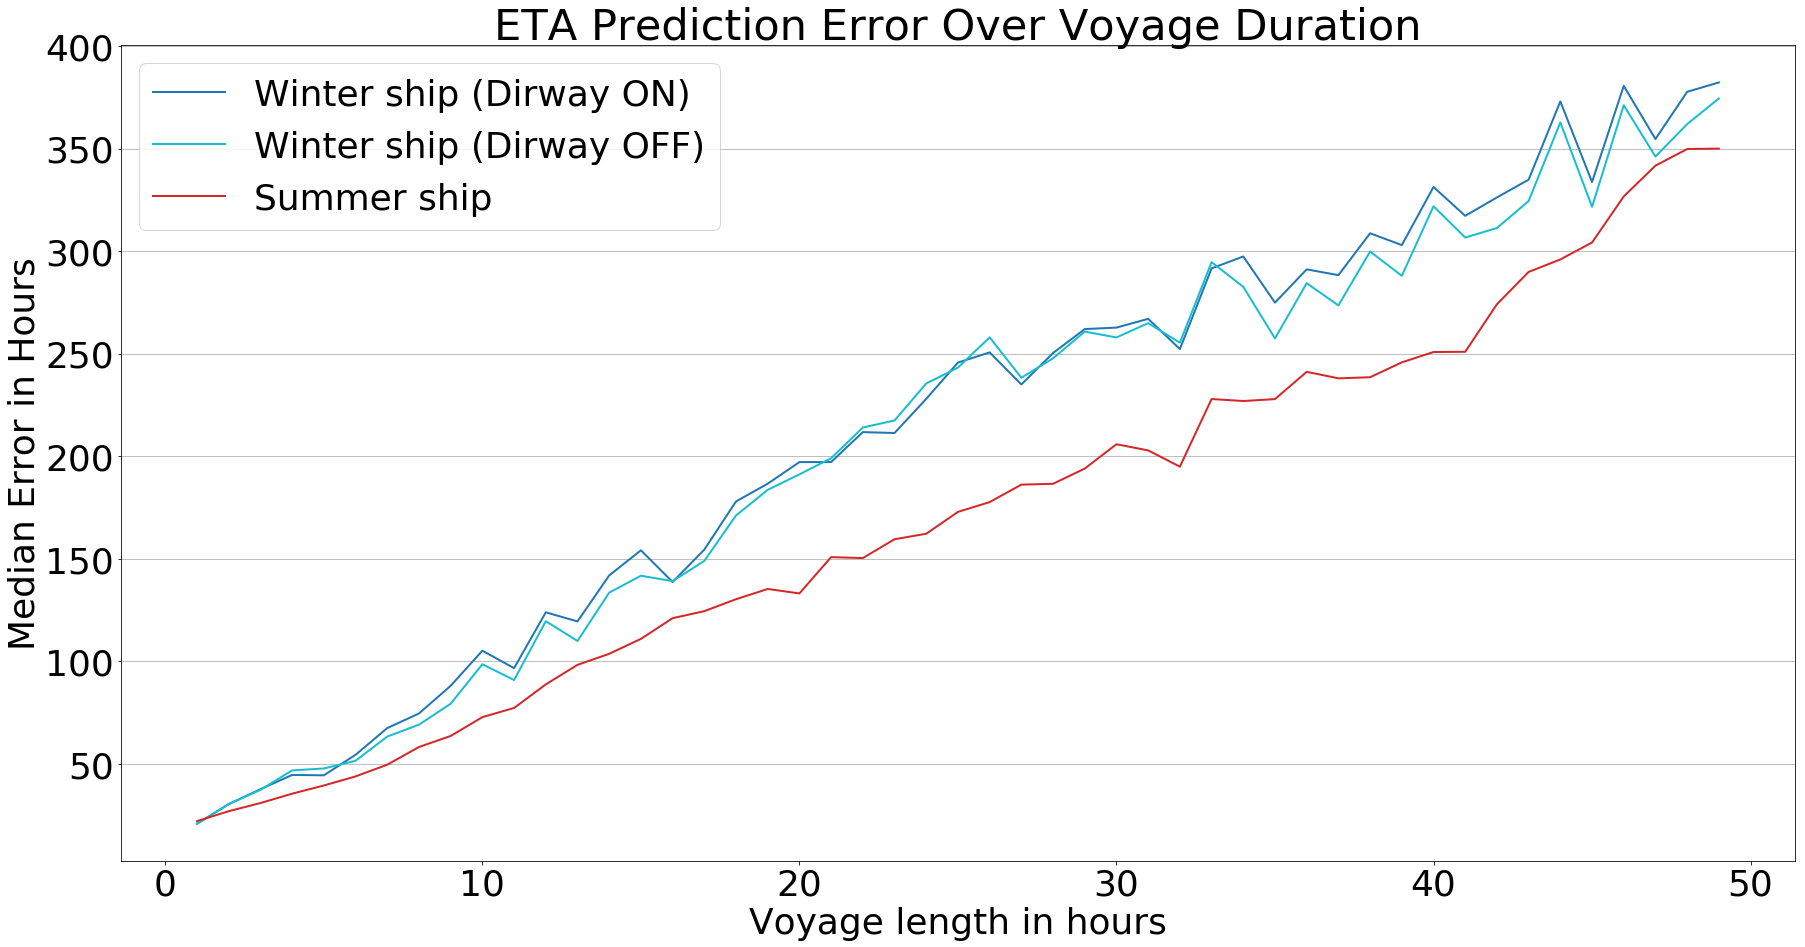

In [34]:
from scipy.interpolate import make_interp_spline, BSpline
importlib.reload(shortest_path)


fig = plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 36})

x, y = shortest_path.plot_intervals(winter_simulated_eta_dirway,'voyage_length_mins', 'diff_mins', 60)
plt.plot(x, y, alpha=1, linewidth=2, c='tab:blue', label='Winter ship (Dirway ON)')

x, y = shortest_path.plot_intervals(winter_simulated_eta_no_dirway,'voyage_length_mins', 'diff_mins', 60)
plt.plot(x, y, alpha=1, linewidth=2, c='tab:cyan', label='Winter ship (Dirway OFF)')

x, y = shortest_path.plot_intervals(summer_simulated_eta_ship,'voyage_length_mins', 'diff_mins', 60)
plt.plot(x, y, alpha=1, linewidth=2, c='tab:red', label='Summer ship')

plt.grid(axis='y', alpha=1)
plt.title(f"ETA Prediction Error Over Voyage Duration")
plt.ylabel("Median Error in Hours")
plt.xlabel("Voyage length in hours")
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
  if label not in newLabels:
    newLabels.append(label)
    newHandles.append(handle)
plt.legend(newHandles, newLabels)
plt.show()


## Results over time by vessel type

#### ETA prediction accuracy by vessel type

In [28]:

vessel_type_accuracies = []
for vessel_type, vessel_type_results in summer_eta_results.groupby('vessel_type'):
    count = len(vessel_type_results.voyage.drop_duplicates())
    accuracy = vessel_type_results.describe().loc[['mean', '50%', 'std'], ['voyage_length_mins', 'diff_mins', 'over_predicted']]
    
    vessel_type_accuracies.append([vessel_type, accuracy.loc['50%', 'diff_mins'] / 60, accuracy.loc['mean', 'diff_mins'] / 60, accuracy.loc['std', 'diff_mins'] / 60, accuracy.loc['50%', 'voyage_length_mins'] / 60, accuracy.loc['mean', 'voyage_length_mins'] / 60, accuracy.loc['std', 'voyage_length_mins'] / 60, count])

vessel_type_accuracies = pd.DataFrame(data=vessel_type_accuracies, columns=['vessel_type', 'median_diff_hours', 'mean_diff_hours', 'std_diff_hours', 'median_voyage_length_hours', 'mean_voyage_length_hours', 'std_voyage_length_hours', 'count'])
vessel_type_accuracies = vessel_type_accuracies.sort_values(by='median_diff_hours')
vessel_type_accuracies.round(2)#.to_excel('summer_ETA_results_vessel_type.xlsx')

,vessel_type,median_diff_hours,mean_diff_hours,std_diff_hours,median_voyage_length_hours,mean_voyage_length_hours,std_voyage_length_hours,count
2,PAS,0.94,1.34,1.99,10.12,11.59,4.66,96
1,GC,1.94,3.18,3.92,24.66,28.21,18.65,159
0,CONT,2.28,2.73,1.51,18.44,19.06,5.33,11
3,RORO,3.12,3.86,3.79,30.83,30.97,11.11,21
4,T,3.36,4.98,5.15,28.39,31.70,17.45,43
